In [32]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image, ImageDraw, ImageOps
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D, BatchNormalization, Dropout

print('Using TensorFlow version', tf.__version__)
print(tf.config.list_physical_devices('GPU'))

np.random.seed(42)
tf.random.set_seed(42)

Using TensorFlow version 2.10.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Process Objects and Textures

(112, 96, 4)


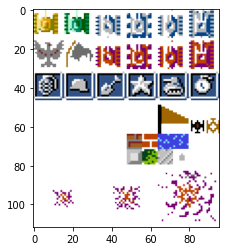

In [2]:
sprites = plt.imread('sprites.gif')
print(sprites.shape)
plt.imshow(sprites)

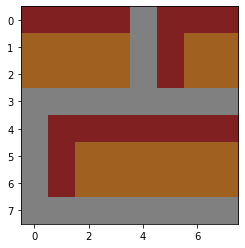

In [3]:
bs = 8
brick = sprites[bs*8:bs*9,bs*6:bs*7]
plt.imshow(brick)

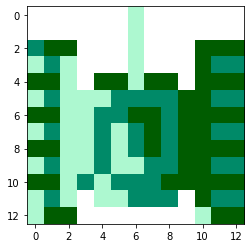

In [4]:
tank = sprites[:bs*2-3,bs*2:bs*4-3]
plt.imshow(tank)

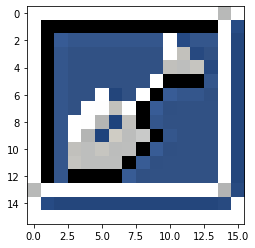

In [5]:
objects = {
    'tanks': [Image.fromarray(sprites[:bs*2-3, bs*2*i:bs*2*i+bs*2-3]) for i in range(2)],
    'enemies': [Image.fromarray(sprites[:bs*2-1,bs*2*i:bs*2*i+bs*2-3]) for i in range(2,6)],
    'boosted_enemies': [sprites[bs*2:bs*4-1,bs*2*i:bs*2*i+bs*2-3] for i in range(2,6)],
    'base': [sprites[bs*2:bs*4-2,bs*2*i:bs*2*i+bs*2] for i in range(2)],
    'bonuses': [sprites[bs*4:bs*6,bs*2*i:bs*2*i+bs*2] for i in range(6)],
}
textures = {
    'brick': Image.fromarray(sprites[bs*8:bs*9,bs*6:bs*7]),
    'water': Image.fromarray(sprites[bs*8:bs*9,bs*8:bs*9]),
    'steel': Image.fromarray(sprites[bs*9:bs*10,bs*6:bs*7]),
    'bush': Image.fromarray(sprites[bs*9:bs*10,bs*7:bs*8]),
    'ice': Image.fromarray(sprites[bs*9:bs*10,bs*8:bs*9]),
}
other = {
    'bullet': [],
    'explodions': [],
    'effects':[],
}

plt.imshow(objects['bonuses'][2])
#objects['bonuses'][2]

### Map Generation

In [6]:
n_maps = 35
ms = 128
maps = np.empty((n_maps,26), dtype='<U26')

for i in range(n_maps):
    with open(f'levels/{i+1}', "r") as f:
        data = f.read().split("\n")
        maps[i, :] = np.array(data)

print(maps.shape)
maps[0]

(35, 26)


array(['..........................', '..........................',
       '..##..##..##..##..##..##..', '..##..##..##..##..##..##..',
       '..##..##..##..##..##..##..', '..##..##..##..##..##..##..',
       '..##..##..##@@##..##..##..', '..##..##..##@@##..##..##..',
       '..##..##..##..##..##..##..', '..##..##..........##..##..',
       '..##..##..........##..##..', '..........##..##..........',
       '..........##..##..........', '##..####..........####..##',
       '@@..####..........####..@@', '..........##..##..........',
       '..........######..........', '..##..##..######..##..##..',
       '..##..##..##..##..##..##..', '..##..##..##..##..##..##..',
       '..##..##..##..##..##..##..', '..##..##..........##..##..',
       '..##..##..........##..##..', '..##..##...####...##..##..',
       '...........#..#...........', '...........#..#...........'],
      dtype='<U26')

In [7]:
with open(f'levels/test', "r") as f:
    data = f.read().split("\n")
    test_map = np.array(data)

In [8]:
def build_city(show_free_space=False):
    data = maps[np.random.randint(n_maps)]
    ts = 2*bs-2

    city = Image.new('RGBA', (ms, ms))

    free_space = np.ones((ms, ms))
    free_space[-ts:,:] = 0
    free_space[:,-ts:] = 0
    
    def block_space(c1,c2):
        free_space[np.clip(c1-ts, 0, ms):c1+bs, np.clip(c2-ts, 0, ms):c2+bs] = 0
    
    #textures
    for i, row in enumerate(data):
        for j, c in enumerate(row):
            if c == '#':
                tx = textures['brick']
            elif c == '@':
                tx = textures['steel']
            elif c == '%':
                tx = textures['bush']
            elif c == '~':
                tx = textures['water']
            elif c == '-':
                tx = textures['ice']
            else:
                continue

            if bs*(i+1) > ms or bs*(j+1) > ms:
                break
            
            city.paste(tx, (bs*j, bs*i), tx)
            block_space(bs*i,bs*j)
    
    #tank
    class_id = np.random.randint(2)
    
    if show_free_space:
        plt.imshow(free_space)
        plt.show()
    
    free_coords = np.array(np.where(free_space == 1)).T
    (c1, c2) = free_coords[np.random.randint(free_coords.shape[0])]
    
    
    if class_id == 0:
        obj = objects['tanks'][0]
    else:
        obj = objects['enemies'][3]
    
    obj = obj.rotate(90 * np.random.randint(4))
    
    city.paste(obj, (c2, c1), obj)
    
    return np.array(city)[:,:,:3], class_id, (c1/ms, c2/ms)

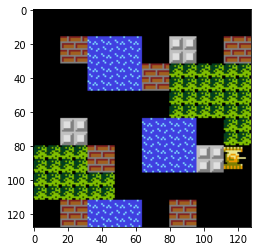

In [9]:
city, class_id, tank_coords = build_city()
plt.imshow(city)

In [10]:
free_space = np.ones((4, 4))
free_space[-1,:] = 0
free_space[:,-1] = 0
free_space

array([[1., 1., 1., 0.],
       [1., 1., 1., 0.],
       [1., 1., 1., 0.],
       [0., 0., 0., 0.]])

$208 \times 208$

In [11]:
def plot_bounding_box(image, gt_coords, pred_coords=[], norm=False):
    row, col = gt_coords
    
    if norm:
        image *= 255.
        image = image.astype('uint8')
        
    image = Image.fromarray(image)
    draw = ImageDraw.Draw(image)
    
    
    row *= ms
    col *= ms
    draw.rectangle((col-3, row-3, col + 15, row + 15), outline='#4CFF52', width=3) #4CFF52
    
    
    if len(pred_coords) == 2:
        row, col = pred_coords
        row *= ms
        col *= ms
        draw.rectangle((col-3, row-3, col + 15, row + 15), outline='#FF229A', width=3) #FF229A
        
    return image

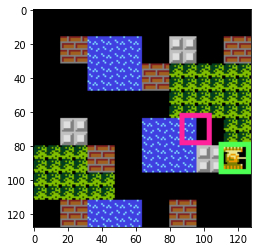

In [12]:
image = plot_bounding_box(city, tank_coords, (0.5, 0.7))
plt.imshow(image)

In [13]:
def data_generator(batch_size=16):
    print(batch_size)
    while True:
        x_batch = np.zeros((batch_size, ms, ms, 3))
        y_batch = np.zeros((batch_size, 2))
        bbox_batch = np.zeros((batch_size, 2))
        
        for i in range(0, batch_size):
            image, class_id, coords = build_city()

            x_batch[i] = image / 255.
            y_batch[i, class_id] = 1.
            bbox_batch[i] = np.array(coords)
        
        yield {'image': x_batch}, {'class_out': y_batch, 'box_out': bbox_batch} # inputs, outputs

1


Text(0.5, 1.0, '0')

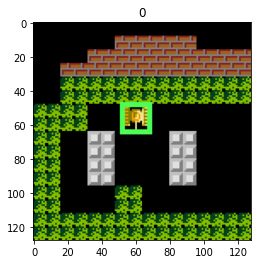

In [14]:
example, label = next(data_generator(1))
image = example['image'][0]
class_id = np.argmax(label['class_out'][0])
coords = label['box_out'][0]

image = plot_bounding_box(image, coords, norm=True)
plt.imshow(image)
plt.title(class_id)

In [15]:
input_ = Input(shape=(ms, ms, 3), name='image')

x = input_

for i in range(0, 5):
    #n_filters = 2**(1 + i)
    n_filters = 2**(2 + i)
    x = Conv2D(n_filters, 3, activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(2)(x)
    
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
    
class_out = Dense(2, activation='softmax', name='class_out')(x)
box_out = Dense(2, name='box_out')(x)

model = tf.keras.models.Model(input_, [class_out, box_out])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 126, 126, 4)  112         ['image[0][0]']                  
                                                                                                  
 batch_normalization (BatchNorm  (None, 126, 126, 4)  16         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

### Metric: IoU

In [16]:
class IoU(tf.keras.metrics.Metric):
    def __init__(self, **kwargs):
        super(IoU, self).__init__(**kwargs)
        
        self.iou = self.add_weight(name='iou', initializer='zeros')
        self.total_iou = self.add_weight(name='total_iou', initializer='zeros')
        self.num_ex = self.add_weight(name='num_ex', initializer='zeros')
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        def get_box(y):
            rows, cols = y[:, 0], y[:, 1]
            rows, cols = rows * 144, cols * 144
            y1, y2 = rows, rows + 52
            x1, x2 = cols, cols + 52
            
            return x1, y1, x2, y2
            
        def get_area(x1, y1, x2, y2):
            return tf.math.abs(x2 - x1) * tf.math.abs(y2 - y1)
            
        gt_x1, gt_y1, gt_x2, gt_y2 = get_box(y_true)
        p_x1, p_y1, p_x2, p_y2 = get_box(y_pred)
        
        i_x1 = tf.maximum(gt_x1, p_x1)
        i_y1 = tf.maximum(gt_y1, p_y1)
        i_x2 = tf.minimum(gt_x2, p_x2)
        i_y2 = tf.minimum(gt_y2, p_y2)
        
        # elements with intersection
        mask = tf.cast(tf.math.logical_and(tf.math.less(i_x1, i_x2), tf.math.less(i_y1, i_y2)), tf.float32)
        
        i_area = tf.math.multiply(get_area(i_x1, i_y1, i_x2, i_y2), mask)
        
        u_area = get_area(gt_x1, gt_y1, gt_x2, gt_y2) + get_area(p_x1, p_y1, p_x2, p_y2) - i_area
        
        iou = tf.math.divide(i_area, u_area)
        
        self.num_ex.assign_add(1)
        self.total_iou.assign_add(tf.reduce_mean(iou))              # ???
        self.iou = tf.math.divide(self.total_iou, self.num_ex)
        
    def result(self):
        return self.iou
    
    def reset_state(self):
        self.iou = self.add_weight(name='iou', initializer='zeros')
        self.total_iou = self.add_weight(name='total_iou', initializer='zeros')
        self.num_ex = self.add_weight(name='num_ex', initializer='zeros')

## Task 8: Compile the Model

In [17]:
model.compile(
    loss={
        'class_out': 'categorical_crossentropy',
        'box_out': 'mse'
    },
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics={
        'class_out': 'accuracy',
        'box_out': IoU(name='iou')
    },
    run_eagerly=True
)

## Task 9: Custom Callback: Model Testing

In [18]:
def test_model(model, test_datagen):
    example, label = next(test_datagen)
    x = example['image']
    y = label['class_out']
    box = label['box_out']
    
    pred_y, pred_box = model.predict(x)
    
    pred_coords = pred_box[0]
    gt_coords = box[0]
    
    pred_class = np.argmax(pred_y[0])
    gt_class = np.argmax(y[0])
    
    image = x[0]
    
    gt = 'tank' if gt_class == 0 else 'enemy'
    pred_class_name = 'tank' if pred_class == 0 else 'enemy'
    
    image = plot_bounding_box(image, gt_coords, pred_coords, norm=True)
    color = 'green' if gt == pred_class_name else 'red'
    
    plt.imshow(image)
    plt.xlabel(f'Pred: {pred_class_name}', color=color)
    plt.ylabel(f'GT: {gt}', color=color)
    plt.xticks([])
    plt.yticks([])
    

In [19]:
def test(model):
    test_datagen = data_generator(1)
    
    plt.figure(figsize=(16, 4))
    
    for i in range(0, 6):
        plt.subplot(1, 6, i + 1)
        test_model(model, test_datagen)
        
    plt.show()

1
1/1 [==============================] - 0s 32ms/step


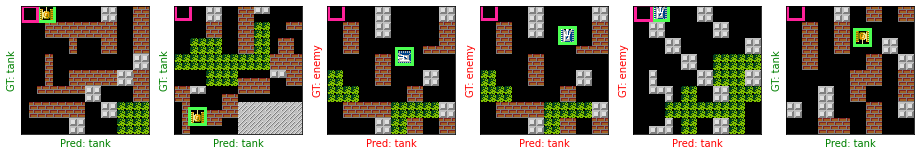

In [20]:
test(model)

In [21]:
class ShowTestImages(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test(self.model)

## Task 10: Model Training

In [22]:
def lr_schedule(epoch, lr):
    if (epoch + 1) % 10 == 0:
        lr *= 0.2
        
    return max(lr, 3e-7)

16
Epoch 1/50
1/1 [==============================] - 0s 22ms/step


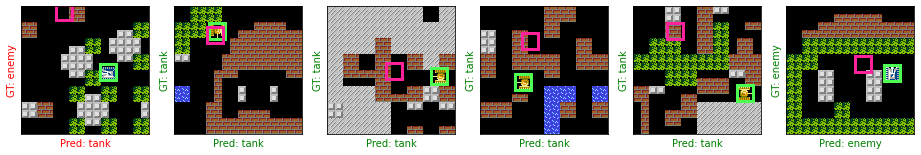

500/500 [==============================] - 81s 157ms/step - loss: 0.6359 - class_out_loss: 0.4480 - box_out_loss: 0.1879 - class_out_accuracy: 0.7719 - box_out_iou: 0.1731 - lr: 0.0100
Epoch 2/50
1/1 [==============================] - 0s 43ms/step


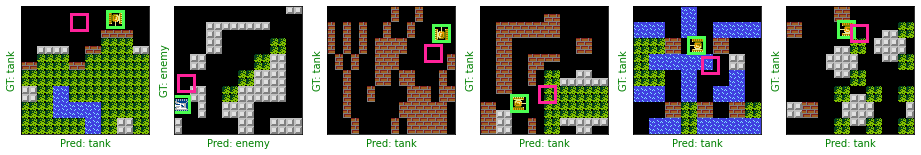

500/500 [==============================] - 77s 154ms/step - loss: 0.0678 - class_out_loss: 0.0289 - box_out_loss: 0.0389 - class_out_accuracy: 0.9908 - box_out_iou: 0.2982 - lr: 0.0100
Epoch 3/50
1/1 [==============================] - 0s 50ms/step


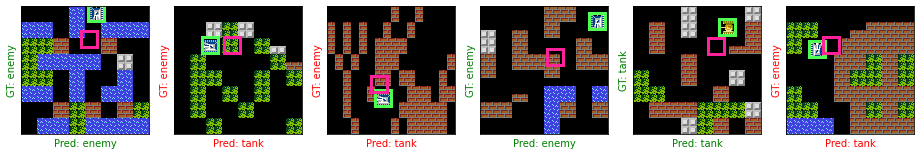

500/500 [==============================] - 75s 151ms/step - loss: 0.0498 - class_out_loss: 0.0183 - box_out_loss: 0.0316 - class_out_accuracy: 0.9964 - box_out_iou: 0.3383 - lr: 0.0100
Epoch 4/50
1/1 [==============================] - 0s 31ms/step


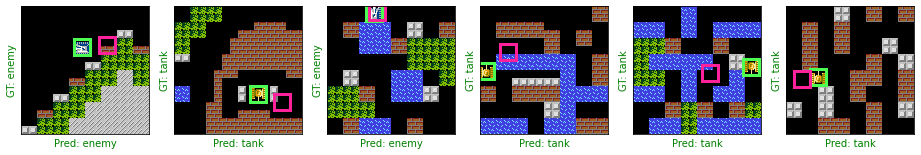

500/500 [==============================] - 75s 151ms/step - loss: 0.0216 - class_out_loss: 0.0021 - box_out_loss: 0.0195 - class_out_accuracy: 0.9994 - box_out_iou: 0.4177 - lr: 0.0100
Epoch 5/50
1/1 [==============================] - 0s 39ms/step


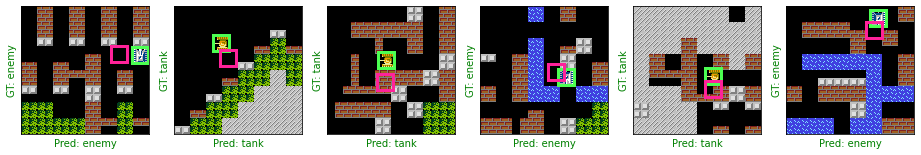

500/500 [==============================] - 75s 151ms/step - loss: 0.0547 - class_out_loss: 0.0290 - box_out_loss: 0.0258 - class_out_accuracy: 0.9919 - box_out_iou: 0.4089 - lr: 0.0100
Epoch 6/50
1/1 [==============================] - 0s 37ms/step


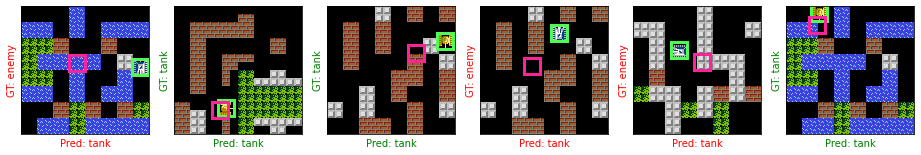

500/500 [==============================] - 77s 155ms/step - loss: 0.0255 - class_out_loss: 0.0135 - box_out_loss: 0.0119 - class_out_accuracy: 0.9970 - box_out_iou: 0.4694 - lr: 0.0100
Epoch 7/50
1/1 [==============================] - 0s 48ms/step


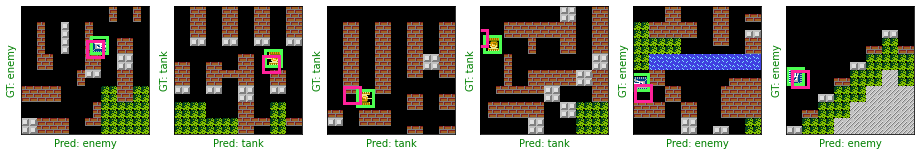

500/500 [==============================] - 78s 157ms/step - loss: 0.0146 - class_out_loss: 0.0065 - box_out_loss: 0.0081 - class_out_accuracy: 0.9990 - box_out_iou: 0.5335 - lr: 0.0100
Epoch 8/50
1/1 [==============================] - 0s 52ms/step


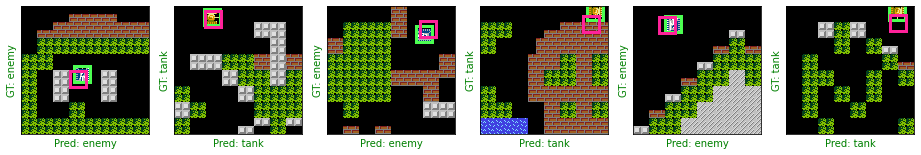

500/500 [==============================] - 79s 159ms/step - loss: 0.0036 - class_out_loss: 1.6241e-04 - box_out_loss: 0.0035 - class_out_accuracy: 1.0000 - box_out_iou: 0.6383 - lr: 0.0100
Epoch 9/50
1/1 [==============================] - 0s 32ms/step


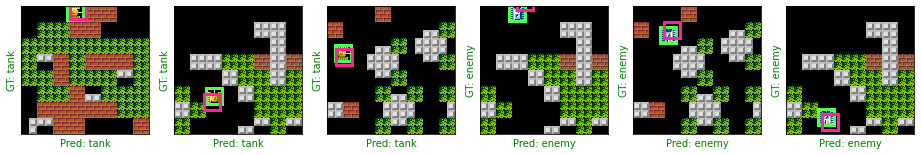

500/500 [==============================] - 79s 157ms/step - loss: 0.0030 - class_out_loss: 1.6016e-04 - box_out_loss: 0.0029 - class_out_accuracy: 1.0000 - box_out_iou: 0.6679 - lr: 0.0100
Epoch 10/50
1/1 [==============================] - 0s 27ms/step


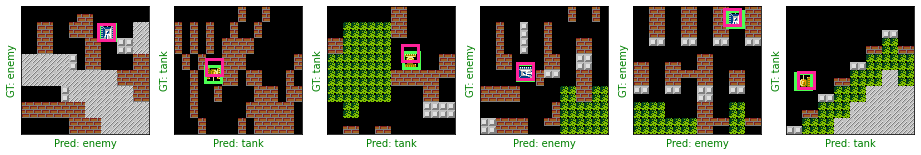

500/500 [==============================] - 84s 169ms/step - loss: 0.0013 - class_out_loss: 7.9974e-05 - box_out_loss: 0.0012 - class_out_accuracy: 1.0000 - box_out_iou: 0.7629 - lr: 0.0020
Epoch 11/50
1/1 [==============================] - 0s 47ms/step


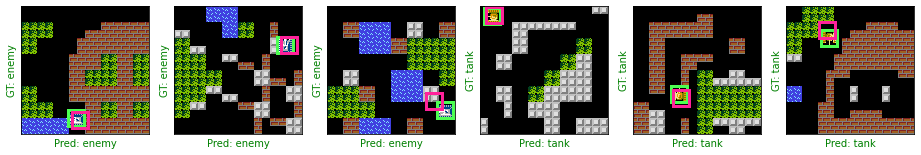

500/500 [==============================] - 85s 169ms/step - loss: 0.0022 - class_out_loss: 4.5989e-04 - box_out_loss: 0.0017 - class_out_accuracy: 0.9998 - box_out_iou: 0.7374 - lr: 0.0020
Epoch 12/50
1/1 [==============================] - 0s 57ms/step


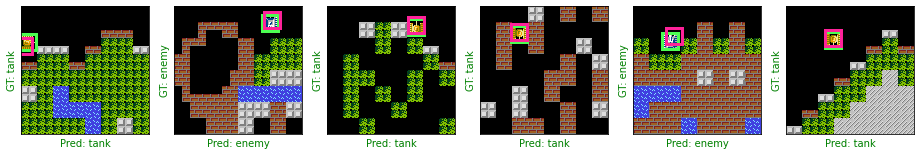

500/500 [==============================] - 86s 171ms/step - loss: 0.0012 - class_out_loss: 5.6684e-05 - box_out_loss: 0.0012 - class_out_accuracy: 1.0000 - box_out_iou: 0.7621 - lr: 0.0020
Epoch 13/50
1/1 [==============================] - 0s 47ms/step


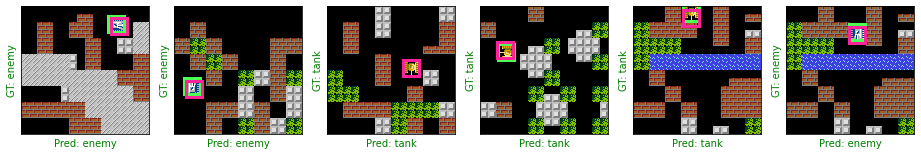

500/500 [==============================] - 85s 170ms/step - loss: 0.0011 - class_out_loss: 3.7140e-05 - box_out_loss: 0.0011 - class_out_accuracy: 1.0000 - box_out_iou: 0.7685 - lr: 0.0020
Epoch 14/50
1/1 [==============================] - 0s 47ms/step


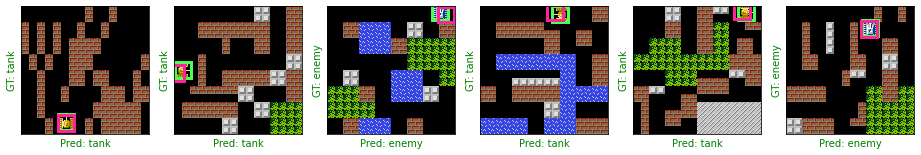

500/500 [==============================] - 84s 168ms/step - loss: 0.0011 - class_out_loss: 2.3650e-05 - box_out_loss: 0.0010 - class_out_accuracy: 1.0000 - box_out_iou: 0.7748 - lr: 0.0020
Epoch 15/50
1/1 [==============================] - 0s 48ms/step


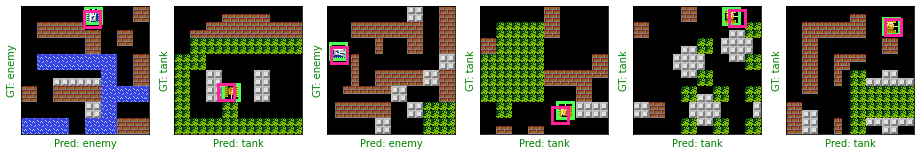

500/500 [==============================] - 85s 169ms/step - loss: 9.5996e-04 - class_out_loss: 2.1600e-05 - box_out_loss: 9.3836e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7822 - lr: 0.0020
Epoch 16/50
1/1 [==============================] - 0s 48ms/step


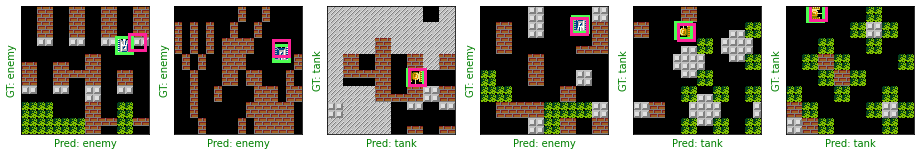

500/500 [==============================] - 85s 170ms/step - loss: 9.0205e-04 - class_out_loss: 2.1643e-05 - box_out_loss: 8.8040e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7880 - lr: 0.0020
Epoch 17/50
1/1 [==============================] - 0s 30ms/step


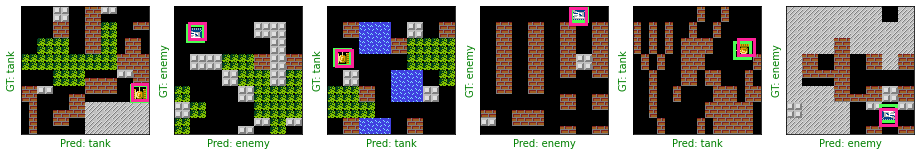

500/500 [==============================] - 85s 170ms/step - loss: 9.6661e-04 - class_out_loss: 6.7553e-05 - box_out_loss: 8.9906e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7872 - lr: 0.0020
Epoch 18/50
1/1 [==============================] - 0s 48ms/step


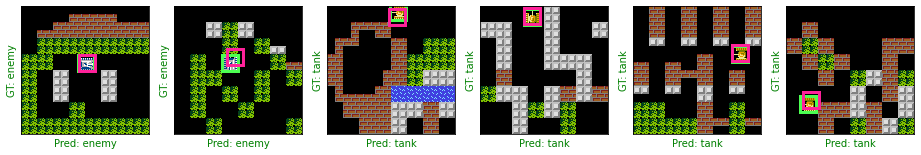

500/500 [==============================] - 84s 169ms/step - loss: 9.0038e-04 - class_out_loss: 2.4853e-05 - box_out_loss: 8.7553e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7884 - lr: 0.0020
Epoch 19/50
1/1 [==============================] - 0s 20ms/step


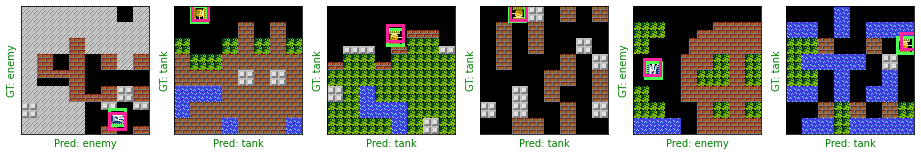

500/500 [==============================] - 85s 170ms/step - loss: 0.0036 - class_out_loss: 0.0012 - box_out_loss: 0.0024 - class_out_accuracy: 0.9995 - box_out_iou: 0.7099 - lr: 0.0020
Epoch 20/50
1/1 [==============================] - 0s 32ms/step


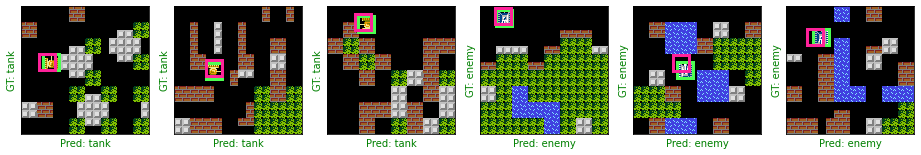

500/500 [==============================] - 85s 170ms/step - loss: 7.6288e-04 - class_out_loss: 3.5002e-05 - box_out_loss: 7.2788e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.8088 - lr: 4.0000e-04
Epoch 21/50
1/1 [==============================] - 0s 63ms/step


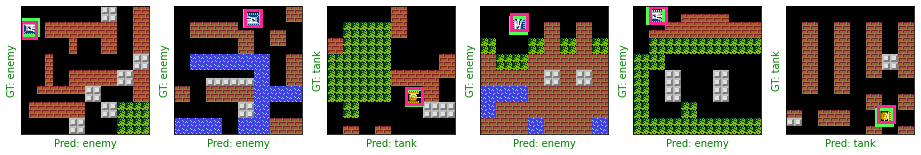

500/500 [==============================] - 85s 169ms/step - loss: 6.7939e-04 - class_out_loss: 1.5563e-05 - box_out_loss: 6.6383e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.8165 - lr: 4.0000e-04
Epoch 22/50
1/1 [==============================] - 0s 61ms/step


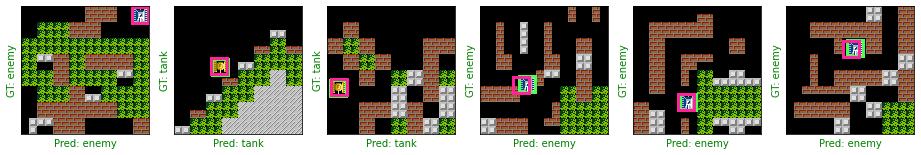

500/500 [==============================] - 84s 169ms/step - loss: 5.6718e-04 - class_out_loss: 1.0250e-05 - box_out_loss: 5.5693e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.8260 - lr: 4.0000e-04
Epoch 23/50
1/1 [==============================] - 0s 25ms/step


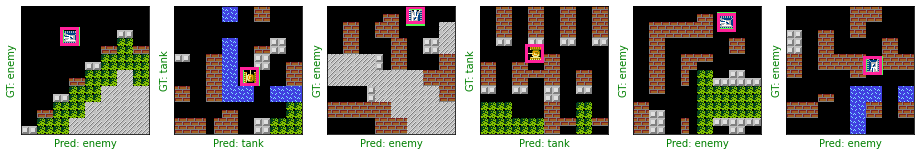

500/500 [==============================] - 84s 168ms/step - loss: 5.5704e-04 - class_out_loss: 1.1529e-05 - box_out_loss: 5.4551e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.8269 - lr: 4.0000e-04
Epoch 24/50
1/1 [==============================] - 0s 63ms/step


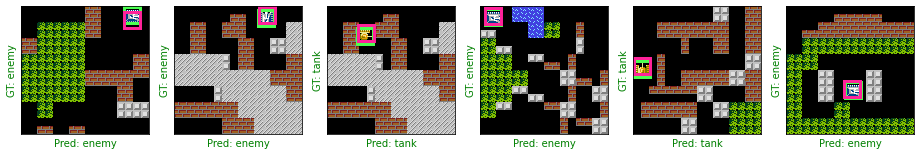

500/500 [==============================] - 85s 170ms/step - loss: 6.3019e-04 - class_out_loss: 1.0387e-04 - box_out_loss: 5.2632e-04 - class_out_accuracy: 0.9999 - box_out_iou: 0.8299 - lr: 4.0000e-04
Epoch 25/50
1/1 [==============================] - 0s 47ms/step


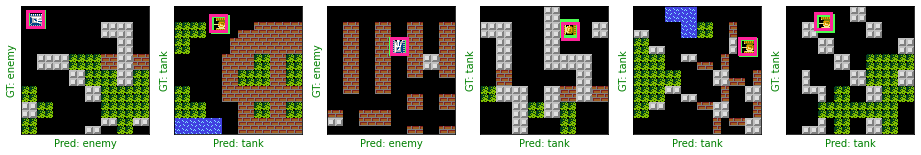

500/500 [==============================] - 84s 169ms/step - loss: 5.0792e-04 - class_out_loss: 8.8822e-06 - box_out_loss: 4.9904e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.8332 - lr: 4.0000e-04
Epoch 26/50
1/1 [==============================] - 0s 48ms/step


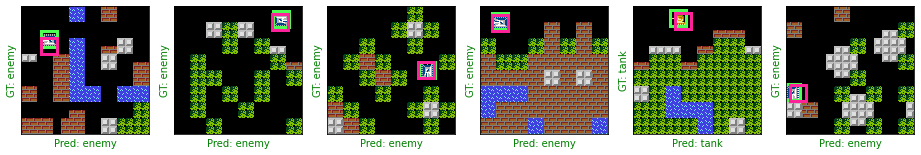

500/500 [==============================] - 86s 172ms/step - loss: 4.7560e-04 - class_out_loss: 7.9100e-06 - box_out_loss: 4.6769e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.8391 - lr: 4.0000e-04
Epoch 27/50
1/1 [==============================] - 0s 45ms/step


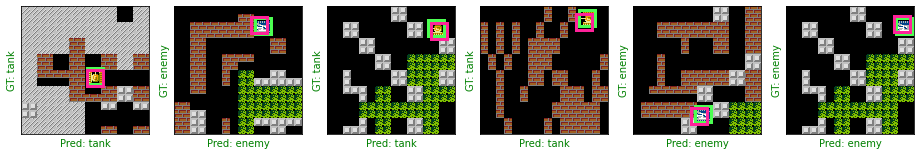

500/500 [==============================] - 85s 170ms/step - loss: 4.4420e-04 - class_out_loss: 6.9620e-06 - box_out_loss: 4.3724e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.8422 - lr: 4.0000e-04
Epoch 28/50
1/1 [==============================] - 0s 48ms/step


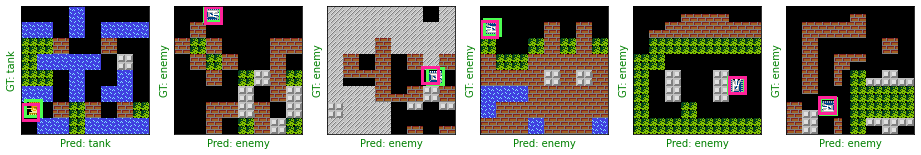

500/500 [==============================] - 85s 170ms/step - loss: 4.4333e-04 - class_out_loss: 6.6558e-06 - box_out_loss: 4.3667e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.8436 - lr: 4.0000e-04
Epoch 29/50
1/1 [==============================] - 0s 29ms/step


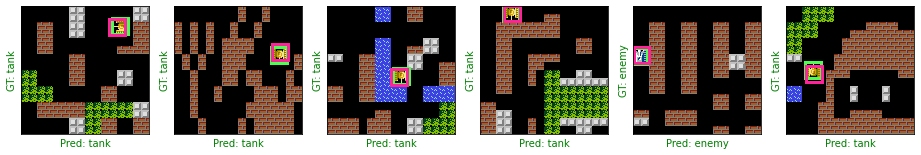

500/500 [==============================] - 86s 171ms/step - loss: 4.2836e-04 - class_out_loss: 5.4501e-06 - box_out_loss: 4.2291e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.8464 - lr: 4.0000e-04
Epoch 30/50
1/1 [==============================] - 0s 48ms/step


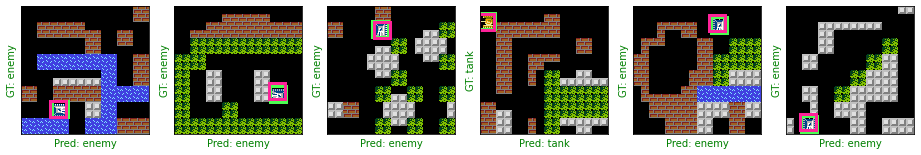

500/500 [==============================] - 85s 170ms/step - loss: 5.0627e-04 - class_out_loss: 1.8092e-04 - box_out_loss: 3.2536e-04 - class_out_accuracy: 0.9999 - box_out_iou: 0.8631 - lr: 8.0000e-05
Epoch 31/50
1/1 [==============================] - 0s 48ms/step


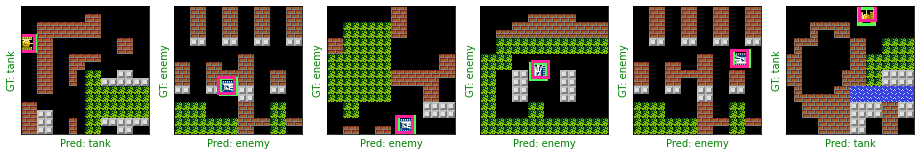

500/500 [==============================] - 338s 677ms/step - loss: 3.1997e-04 - class_out_loss: 3.3506e-06 - box_out_loss: 3.1662e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.8641 - lr: 8.0000e-05
Epoch 32/50
1/1 [==============================] - 0s 48ms/step


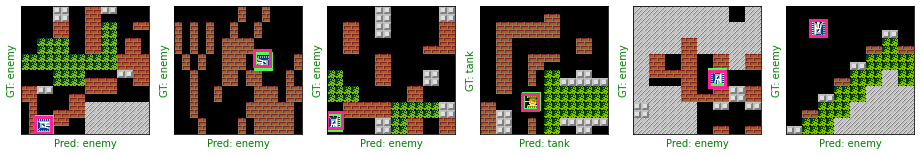

500/500 [==============================] - 80s 160ms/step - loss: 3.0011e-04 - class_out_loss: 2.5285e-06 - box_out_loss: 2.9758e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.8674 - lr: 8.0000e-05
Epoch 33/50
1/1 [==============================] - 0s 31ms/step


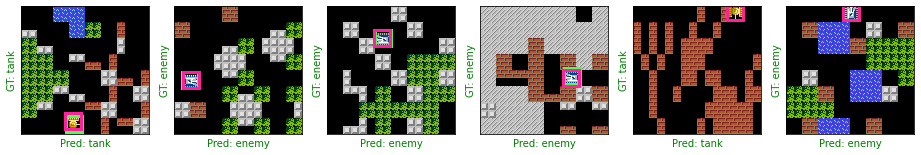

500/500 [==============================] - 77s 155ms/step - loss: 3.0753e-04 - class_out_loss: 3.0307e-06 - box_out_loss: 3.0450e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.8668 - lr: 8.0000e-05
Epoch 34/50
1/1 [==============================] - 0s 32ms/step


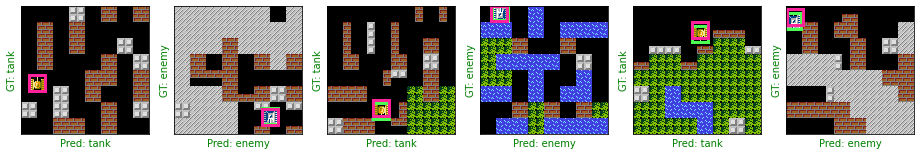

500/500 [==============================] - 77s 155ms/step - loss: 2.9688e-04 - class_out_loss: 2.7428e-06 - box_out_loss: 2.9413e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.8682 - lr: 8.0000e-05
Epoch 35/50
1/1 [==============================] - 0s 36ms/step


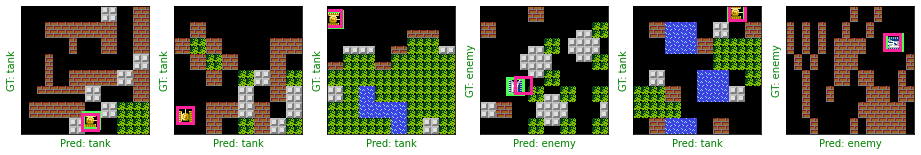

500/500 [==============================] - 79s 159ms/step - loss: 2.8875e-04 - class_out_loss: 2.2750e-06 - box_out_loss: 2.8647e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.8701 - lr: 8.0000e-05
Epoch 36/50
1/1 [==============================] - 0s 47ms/step


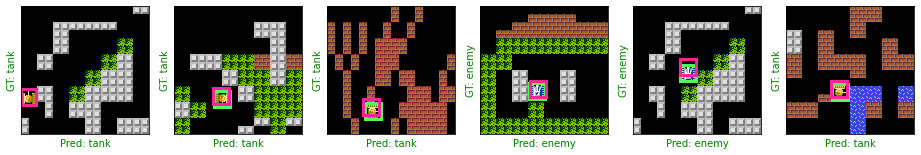

500/500 [==============================] - 79s 159ms/step - loss: 2.8977e-04 - class_out_loss: 3.9898e-06 - box_out_loss: 2.8578e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.8704 - lr: 8.0000e-05
Epoch 37/50
1/1 [==============================] - 0s 47ms/step


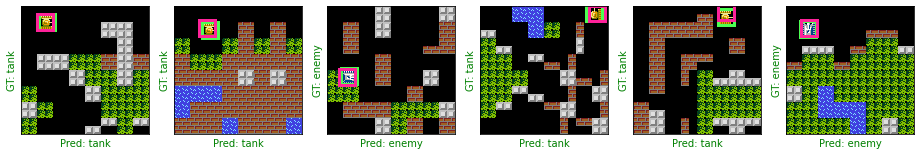

500/500 [==============================] - 80s 160ms/step - loss: 2.8407e-04 - class_out_loss: 1.9835e-06 - box_out_loss: 2.8209e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.8704 - lr: 8.0000e-05
Epoch 38/50
1/1 [==============================] - 0s 31ms/step


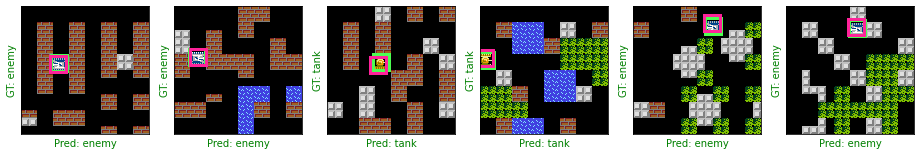

500/500 [==============================] - 95s 190ms/step - loss: 2.7487e-04 - class_out_loss: 2.2079e-06 - box_out_loss: 2.7266e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.8727 - lr: 8.0000e-05
Epoch 39/50
1/1 [==============================] - 0s 49ms/step


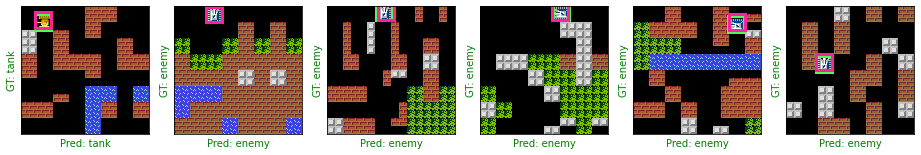

500/500 [==============================] - 78s 157ms/step - loss: 2.5764e-04 - class_out_loss: 1.6021e-06 - box_out_loss: 2.5604e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.8751 - lr: 8.0000e-05
Epoch 40/50
1/1 [==============================] - 0s 50ms/step


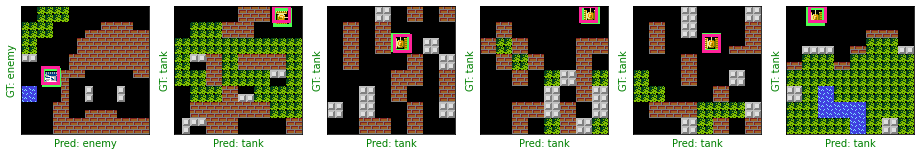

500/500 [==============================] - 78s 157ms/step - loss: 0.0011 - class_out_loss: 8.7604e-04 - box_out_loss: 2.5424e-04 - class_out_accuracy: 0.9999 - box_out_iou: 0.8760 - lr: 1.6000e-05
Epoch 41/50
1/1 [==============================] - 0s 38ms/step


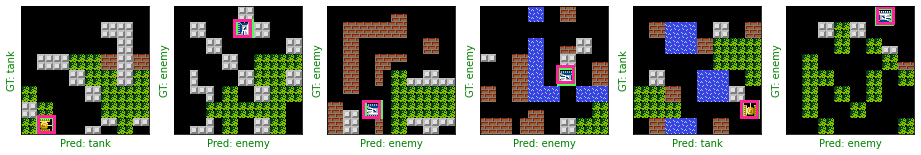

500/500 [==============================] - 78s 157ms/step - loss: 2.5279e-04 - class_out_loss: 1.2301e-05 - box_out_loss: 2.4049e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.8792 - lr: 1.6000e-05
Epoch 42/50
1/1 [==============================] - 0s 41ms/step


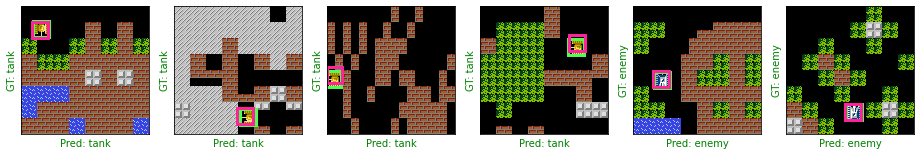

500/500 [==============================] - 77s 154ms/step - loss: 2.3840e-04 - class_out_loss: 1.5600e-06 - box_out_loss: 2.3684e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.8804 - lr: 1.6000e-05
Epoch 43/50
1/1 [==============================] - 0s 51ms/step


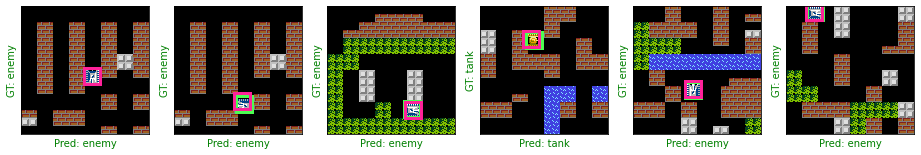

500/500 [==============================] - 76s 152ms/step - loss: 2.6128e-04 - class_out_loss: 2.5136e-06 - box_out_loss: 2.5877e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.8761 - lr: 1.6000e-05
Epoch 44/50
1/1 [==============================] - 0s 53ms/step


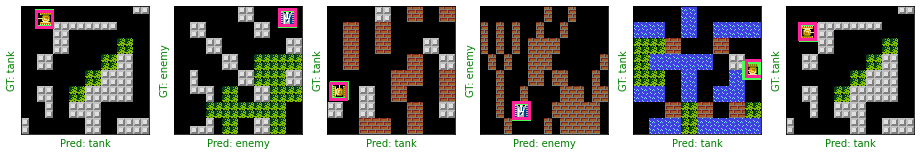

500/500 [==============================] - 76s 152ms/step - loss: 2.5135e-04 - class_out_loss: 1.6338e-06 - box_out_loss: 2.4971e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.8782 - lr: 1.6000e-05
Epoch 45/50
1/1 [==============================] - 0s 40ms/step


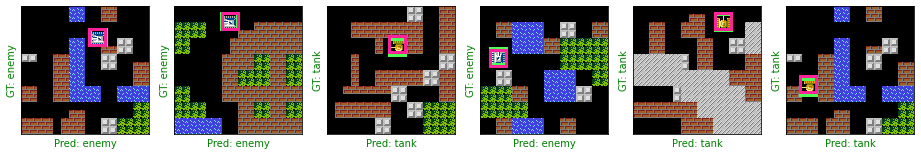

500/500 [==============================] - 77s 154ms/step - loss: 9.4627e-04 - class_out_loss: 6.9157e-04 - box_out_loss: 2.5469e-04 - class_out_accuracy: 0.9999 - box_out_iou: 0.8781 - lr: 1.6000e-05


In [23]:
history = model.fit(
    data_generator(),
    epochs=50,
    steps_per_epoch=500,
    callbacks=[
        ShowTestImages(),
        tf.keras.callbacks.EarlyStopping(monitor='box_out_iou', patience=3, mode='max'),
        tf.keras.callbacks.LearningRateScheduler(lr_schedule)
    ]
)

In [27]:
history.history

{'loss': [0.6358885169029236,
  0.06779517978429794,
  0.049841102212667465,
  0.021619992330670357,
  0.05473942309617996,
  0.025464095175266266,
  0.014630479738116264,
  0.0036249367985874414,
  0.0030253164004534483,
  0.0012746594147756696,
  0.0022007962688803673,
  0.0012423143489286304,
  0.0011246290523558855,
  0.0010733362287282944,
  0.0009599613258615136,
  0.0009020472643896937,
  0.0009666116093285382,
  0.000900380196981132,
  0.0035685000475496054,
  0.0007628786843270063,
  0.0006793947541154921,
  0.0005671811522915959,
  0.0005570385837927461,
  0.0006301903631538153,
  0.0005079173715785146,
  0.0004756033595185727,
  0.00044420294580049813,
  0.0004433283756952733,
  0.00042835812200792134,
  0.000506271724589169,
  0.0003199696948286146,
  0.00030011028866283596,
  0.0003075335407629609,
  0.0002968768822029233,
  0.00028874646523036063,
  0.0002897732483688742,
  0.00028407463105395436,
  0.0002748717088252306,
  0.0002576419501565397,
  0.001130277058109641,
 

In [26]:
model.save_weights("model128_87.h5")